In [ ]:
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, AveragePooling3D, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dropout, LeakyReLU, Flatten, Dense, TimeDistributed
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, Callback
from keras.utils import Sequence

from vis.visualization import visualize_saliency
from vis.utils import utils

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

import sys
import gc
from time import time
import os
import random

from google.colab import drive

# sys.path.append(‘[Folder name]’)
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
def preprocessing(start_num, end_num):
  """
  pre-processing

  Precondition: fMRI data stored in dataset
  Postcondition: processed data is returned as np arrays

  @returns all data for each participant + one hot encoded labels
  """
  # objective runs to access
  run_nums = [1, 2, 4, 8, 9]
  # the amount of runs we want to loop through
  iter_runs = 1

  # instance variables
  start_people = start_num
  end_people = end_num
  num_people = end_people - start_people + 1
  THRESH = 100
  iter = 0  # number of run iterations

  # preallocate numpy arrays
  processed_fmri = np.empty([num_people * iter_runs, 209, 42, 80, 80], dtype=np.float32)
  processed_binary = np.empty([num_people * iter_runs, 209], dtype=np.uint16)

  for p in range(start_people, end_people + 1):
    for r in random.sample(run_nums, iter_runs):
      bold_dir = r'sub-0{0}/func/sub-0{0}_task-heatpainwithregulationandratings_run-0{1}_bold.nii.gz'.format(p, r)
      event_dir = r'sub-0{0}/func/sub-0{0}_task-heatpainwithregulationandratings_run-0{1}_events.tsv'.format(p, r)
      if p >= 10:
          bold_dir = r'sub-{0}/func/sub-{0}_task-heatpainwithregulationandratings_run-0{1}_bold.nii.gz'.format(p, r)
          event_dir = r'sub-{0}/func/sub-{0}_task-heatpainwithregulationandratings_run-0{1}_events.tsv'.format(p, r)

      t_bold_path = os.path.join(r'drive/My Drive/NISR', bold_dir)
      t_event_path = os.path.join(r'drive/My Drive/NISR', event_dir)

      # images
      img = nib.load(t_bold_path)
      # print(img.header)
      img_data = np.asarray(img.dataobj)
      processed_fmri[iter] = img_data.T
      # print("img_data" in locals())
      # print("img" in locals())
      print('partcipant', p, ', iter:', iter)
      print('run #:', r)

      # events
      df = pd.read_csv(t_event_path, sep='\t', header=0)
      df = df['ratings'].values

      count_not_nan = 0  # counter variable for non-nan values
      run_events = np.empty(11, dtype=np.uint16)
      for i in df:
          if not np.isnan(i):
              if i >= THRESH:
                  run_events[count_not_nan] = 0
              else:
                  run_events[count_not_nan] = 1
              count_not_nan += 1

      run_events = np.repeat(run_events, 19)
      processed_binary[iter] = run_events

      # delocalize variables
      img.uncache()
      del img_data, img
      del run_events, df
      del t_bold_path, t_event_path
      del bold_dir, event_dir

      iter += 1  # increment loop variable

  processed_fmri = processed_fmri.reshape(processed_fmri.shape[0] * processed_fmri.shape[1], 42, 80, 80)
  processed_binary = processed_binary.reshape(processed_binary.shape[0] * processed_binary.shape[1])

  print('Processed fmri shape:', processed_fmri.shape)
  print('Processed binary shape:', processed_binary.shape)

  print('processed_fmri', processed_fmri.nbytes / 1_000_000_000, 'gb')
  print('processed_binary', processed_binary.nbytes / 1_000_000_000, 'gb')

  # memory usage is doubled during split
  print('before split')

  X_train, X_test, y_train, y_test = train_test_split(processed_fmri, processed_binary)
  print('X_train:', X_train.nbytes / 1_000_000_000, 'gb')
  print('y_train:', y_train.nbytes / 1_000_000_000, 'gb')
  print('X_test:', X_test.nbytes / 1_000_000_000, 'gb')
  print('y_test:', y_test.nbytes / 1_000_000_000, 'gb')

  print('after split')

  del processed_fmri, processed_binary

  print('X_train shape', X_train.shape)
  print('y_train shape', y_train.shape)
  print('X_test shape', X_test.shape)
  print('y_test shape', y_test.shape)

  return X_train, X_test, y_train, y_test

In [ ]:
"""
Custom garbage collection callback class
"""
class GarbageCollection(Callback):
  def on_epoch_end(self, epoch, logs=None):
    gc.collect()

In [ ]:
# """
# https://towardsdatascience.com/implementing-custom-data-generators-in-keras-de56f013581c
# Custom data generator class
# """
# class DataGenerator(Sequence):
#   def __init__(self, df, x_col, y_col=None, batch_size=32, num)

In [ ]:
class GridSearchPainNet:
    def __init__(self):
        self.X_train, self.X_test, self.y_train, self.y_test = preprocessing(1, 10)

        self.start = time()
        self.model = self.grid_search()

        self.best_model = None

    # make sure to add "self" parameter when referring to nonstatic context
    def generate_model_2d(self, pool_type='average', dropout_rate=0):
        cnn = Sequential()

        cnn.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(42, 80, 80),
                       data_format='channels_first', activation='relu', kernel_regularizer=l2(0.01)))
        if pool_type == 'average':
            cnn.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
        cnn.add(BatchNormalization())
        if dropout_rate != 0:
            cnn.add(Dropout(dropout_rate))

        for filter_num in range(0, 4):
            # filters double every set of layers
            cnn.add(Conv2D(filters=64*2**filter_num, kernel_size=(3, 3), activation='relu', padding='same'))
            if pool_type == 'average':
                cnn.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
            cnn.add(BatchNormalization())
            if dropout_rate != 0:
                cnn.add(Dropout(dropout_rate))

        cnn.add(Flatten())

        cnn.add(Dense(512, activation='relu'))
        # note: no dropout between dense layers
        cnn.add(Dense(1, activation='sigmoid'))

        # try Adam, SGD, RMSProp
        cnn.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['acc'])
        cnn.summary()

        return cnn

    def grid_search(self):
        # don't put too many parameters to conserve time
        # put in more for now
        parameters = [{
            'pool_type': ['average'],
            'epochs': [5],
            'dropout_rate': [0.10]
        }]

        scitkit_wrapper_model = KerasClassifier(build_fn=self.generate_model_2d, verbose=1)

        clf = GridSearchCV(estimator=scitkit_wrapper_model, param_grid=parameters, scoring='accuracy')

        return clf

    def show_grid_search_performance(self, results):
        print('duration of grid search processing = {:.0f} sec'.format(time() - self.start))

        print('Best score = {:.4f} using {}'.format(results.best_score_, results.best_params_))
        all_means = results.cv_results_['mean_test_score']
        all_stds = results.cv_results_['std_test_score']
        all_params = results.cv_results_['params']

        for mean, stds, params in zip(all_means, all_stds, all_params):
            print('mean_test_accuracy +/- std = {:.4f} +/- {:.4f} with: {}'.format(mean, stds, params))

    def fit(self):
        early_stop = EarlyStopping(monitor='val_loss', mode='max', patience=5, restore_best_weights=True)

        history = self.model.fit(self.X_train, self.y_train, batch_size=10, validation_data=(self.X_test, self.y_test),
                                 callbacks=[early_stop, GarbageCollection()], verbose=1, shuffle=True)

        # self.show_history(history)

        self.show_grid_search_performance(history)

        # assignation of best model
        self.best_model = history.best_estimator_.model

    @staticmethod
    def show_history(history):
        # show training/testing loss over time
        training_loss = history.history['loss']
        test_loss = history.history['val_loss']
        epoch_count = range(1, len(training_loss) + 1)

        plt.plot(epoch_count, training_loss, 'r--')
        plt.plot(epoch_count, test_loss, 'b-')
        plt.legend(['Training Loss', 'Test Loss'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

        # show accuracy and validation accuracy over time
        acc = history.history['acc']
        val_acc = history.history['val_acc']

        plt.plot(epoch_count, acc, 'c-')
        plt.plot(epoch_count, val_acc, 'g--')
        plt.legend(['Accuracy', 'Validation Accuracy'])
        plt.xlabel('Epoch')
        plt.ylabel('Acc')
        plt.show()

    def predict(self, x):
        return (self.model.predict(x) > 0.5).astype("int32")

    def evalute(self):
        evaluation = self.best_model.evaluate(self.X_test, self.y_test)
        print(evaluation)

In [ ]:
grid_search = GridSearchPainNet()

partcipant 1 , iter: 0
run #: 1
partcipant 1 , iter: 1
run #: 4
partcipant 2 , iter: 2
run #: 2
partcipant 2 , iter: 3
run #: 1
partcipant 3 , iter: 4
run #: 1
partcipant 3 , iter: 5
run #: 2
partcipant 4 , iter: 6
run #: 8
partcipant 4 , iter: 7
run #: 1
partcipant 5 , iter: 8
run #: 8
partcipant 5 , iter: 9
run #: 2
partcipant 6 , iter: 10
run #: 9
partcipant 6 , iter: 11
run #: 4
partcipant 7 , iter: 12
run #: 1
partcipant 7 , iter: 13
run #: 4
partcipant 8 , iter: 14
run #: 2
partcipant 8 , iter: 15
run #: 1
partcipant 9 , iter: 16
run #: 2
partcipant 9 , iter: 17
run #: 8
partcipant 10 , iter: 18
run #: 4
partcipant 10 , iter: 19
run #: 2
Processed fmri shape: (4180, 42, 80, 80)
Processed binary shape: (4180,)
processed_fmri 4.494336 gb
processed_binary 8.36e-06 gb
before split
X_train: 3.370752 gb
y_train: 6.27e-06 gb
X_test: 1.123584 gb
y_test: 2.09e-06 gb
after split
X_train shape (3135, 42, 80, 80)
y_train shape (3135,)
X_test shape (1045, 42, 80, 80)
y_test shape (1045,)


In [ ]:
grid_search.fit()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 78, 78)        12128     
_________________________________________________________________
average_pooling2d (AveragePo (None, 16, 39, 78)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 39, 78)        312       
_________________________________________________________________
dropout (Dropout)            (None, 16, 39, 78)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 39, 64)        44992     
_________________________________________________________________
average_pooling2d_1 (Average (None, 8, 19, 64)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 19, 64)         2

In [ ]:
# runtime memory is reset, so load new batch of data
X_train, X_test, y_train, y_test = preprocessing(11, 20)

partcipant 11 , iter: 0
run #: 2
partcipant 12 , iter: 1
run #: 9
partcipant 13 , iter: 2
run #: 1
partcipant 14 , iter: 3
run #: 1
partcipant 15 , iter: 4
run #: 9
partcipant 16 , iter: 5
run #: 2
partcipant 17 , iter: 6
run #: 4
partcipant 18 , iter: 7
run #: 9
partcipant 19 , iter: 8
run #: 4
partcipant 20 , iter: 9
run #: 9
Processed fmri shape: (2090, 42, 80, 80)
Processed binary shape: (2090,)
processed_fmri 2.247168 gb
processed_binary 4.18e-06 gb
before split
X_train: 1.6848384 gb
y_train: 3.134e-06 gb
X_test: 0.5623296 gb
y_test: 1.046e-06 gb
after split
X_train shape (1567, 42, 80, 80)
y_train shape (1567,)
X_test shape (523, 42, 80, 80)
y_test shape (523,)


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 32, 78, 78)        12128     
_________________________________________________________________
average_pooling2d_25 (Averag (None, 16, 39, 78)        0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 16, 39, 78)        312       
_________________________________________________________________
dropout_25 (Dropout)         (None, 16, 39, 78)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 39, 64)        44992     
_________________________________________________________________
average_pooling2d_26 (Averag (None, 8, 19, 64)         0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 8, 19, 64)        

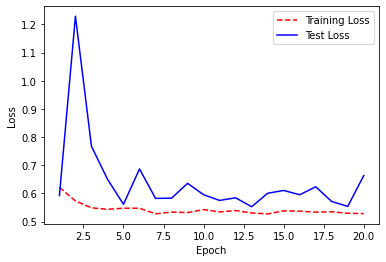

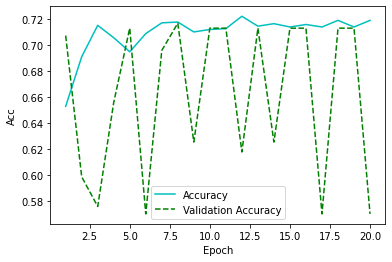

In [ ]:
grid_search.best_model.summary()
history = grid_search.best_model.fit(X_train, y_train, batch_size=10, validation_data=(X_test, y_test), epochs=20,
                                 callbacks=[GarbageCollection()], verbose=1, shuffle=True)
grid_search.show_history(history)

In [ ]:
# runtime memory is reset, so load new batch of data
X_train, X_test, y_train, y_test = preprocessing(21, 32)

partcipant 21 , iter: 0
run #: 1
partcipant 22 , iter: 1
run #: 1
partcipant 23 , iter: 2
run #: 4
partcipant 24 , iter: 3
run #: 9
partcipant 25 , iter: 4
run #: 8
partcipant 26 , iter: 5
run #: 8
partcipant 27 , iter: 6
run #: 2
partcipant 28 , iter: 7
run #: 4
partcipant 29 , iter: 8
run #: 9
partcipant 30 , iter: 9
run #: 1
partcipant 31 , iter: 10
run #: 1
partcipant 32 , iter: 11
run #: 4
Processed fmri shape: (2508, 42, 80, 80)
Processed binary shape: (2508,)
processed_fmri 2.6966016 gb
processed_binary 5.016e-06 gb
before split
X_train: 2.0224512 gb
y_train: 3.762e-06 gb
X_test: 0.6741504 gb
y_test: 1.254e-06 gb
after split
X_train shape (1881, 42, 80, 80)
y_train shape (1881,)
X_test shape (627, 42, 80, 80)
y_test shape (627,)


Epoch 1/20
189/189 [==============================] - 2s 13ms/step - loss: 0.6467 - acc: 0.6385 - val_loss: 0.6809 - val_acc: 0.6061
Epoch 2/20
189/189 [==============================] - 2s 13ms/step - loss: 0.6441 - acc: 0.6401 - val_loss: 0.6558 - val_acc: 0.6204
Epoch 3/20
189/189 [==============================] - 2s 13ms/step - loss: 0.6416 - acc: 0.6443 - val_loss: 0.6574 - val_acc: 0.6140
Epoch 4/20
189/189 [==============================] - 2s 13ms/step - loss: 0.6437 - acc: 0.6257 - val_loss: 0.6525 - val_acc: 0.6172
Epoch 5/20
189/189 [==============================] - 2s 13ms/step - loss: 0.6396 - acc: 0.6411 - val_loss: 0.6547 - val_acc: 0.5917
Epoch 6/20
189/189 [==============================] - 2s 13ms/step - loss: 0.6483 - acc: 0.6321 - val_loss: 0.6557 - val_acc: 0.6396
Epoch 7/20
189/189 [==============================] - 2s 13ms/step - loss: 0.6409 - acc: 0.6438 - val_loss: 0.6686 - val_acc: 0.6077
Epoch 8/20
189/189 [==============================] - 2s 13ms/step - 

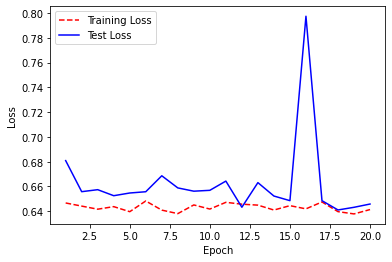

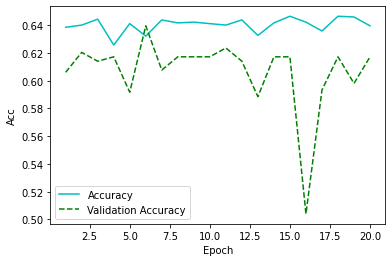

In [ ]:
history = grid_search.best_model.fit(X_train, y_train, batch_size=10, validation_data=(X_test, y_test), epochs=20,
                                 callbacks=[GarbageCollection()], verbose=1, shuffle=True)
grid_search.show_history(history)

In [ ]:
grid_search.best_model.evaluate(X_test, y_test)

20/20 [==============================] - 0s 16ms/step - loss: 0.6458 - acc: 0.6172


[0.6458069682121277, 0.6172248721122742]